# Read the data and rename some parameters
Ref: He et al., 2011, SIMULATING TRANSIENT CLIMATE EVOLUTION OF THE LAST DEGLACIATION WITH CCSM3

In [33]:
import xarray as xr

# import .nc data
ds = xr.open_dataset('data/trace.01-36.22000BP.cam2.TREFHT.22000BP_decavg_400BCE.nc')

# rename the TREFHT to sat
ds = ds.rename({'TREFHT': 'sat'})
# rename the time to age
ds = ds.rename({'time': 'age'})
# multiply age by 1000
ds['age'] = ds['age'] * -1000

# convert the sat to degrees C
ds['sat'] = ds['sat'] - 273.15

ds = ds[['sat']]

# Plot the temperature difference between the first and last data point

In [2]:
# plot the amplitude of deglacial warming
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_sat(ds):
    # extract the first value of 'sat'
    sat =ds['sat'].isel(age=-1)- ds['sat'].isel(age=0)

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()),dpi=300)

    # add coastline and gridlines
    ax.add_feature(cfeature.COASTLINE)
    ax.gridlines()

    # plot heatmap
    cmap = plt.cm.get_cmap('YlOrRd')
    im = ax.pcolormesh(ds.lon, ds.lat, sat, transform=ccrs.PlateCarree(), cmap=cmap, shading='auto')
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Amplitude of deglacial warming (T in age={int(ds.age.values[-1])} minors T in age={int(ds.age.values[0])})')

    # add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
    cbar.ax.set_ylabel('Delta SAT')

    # set title and show plot
    plt.show()


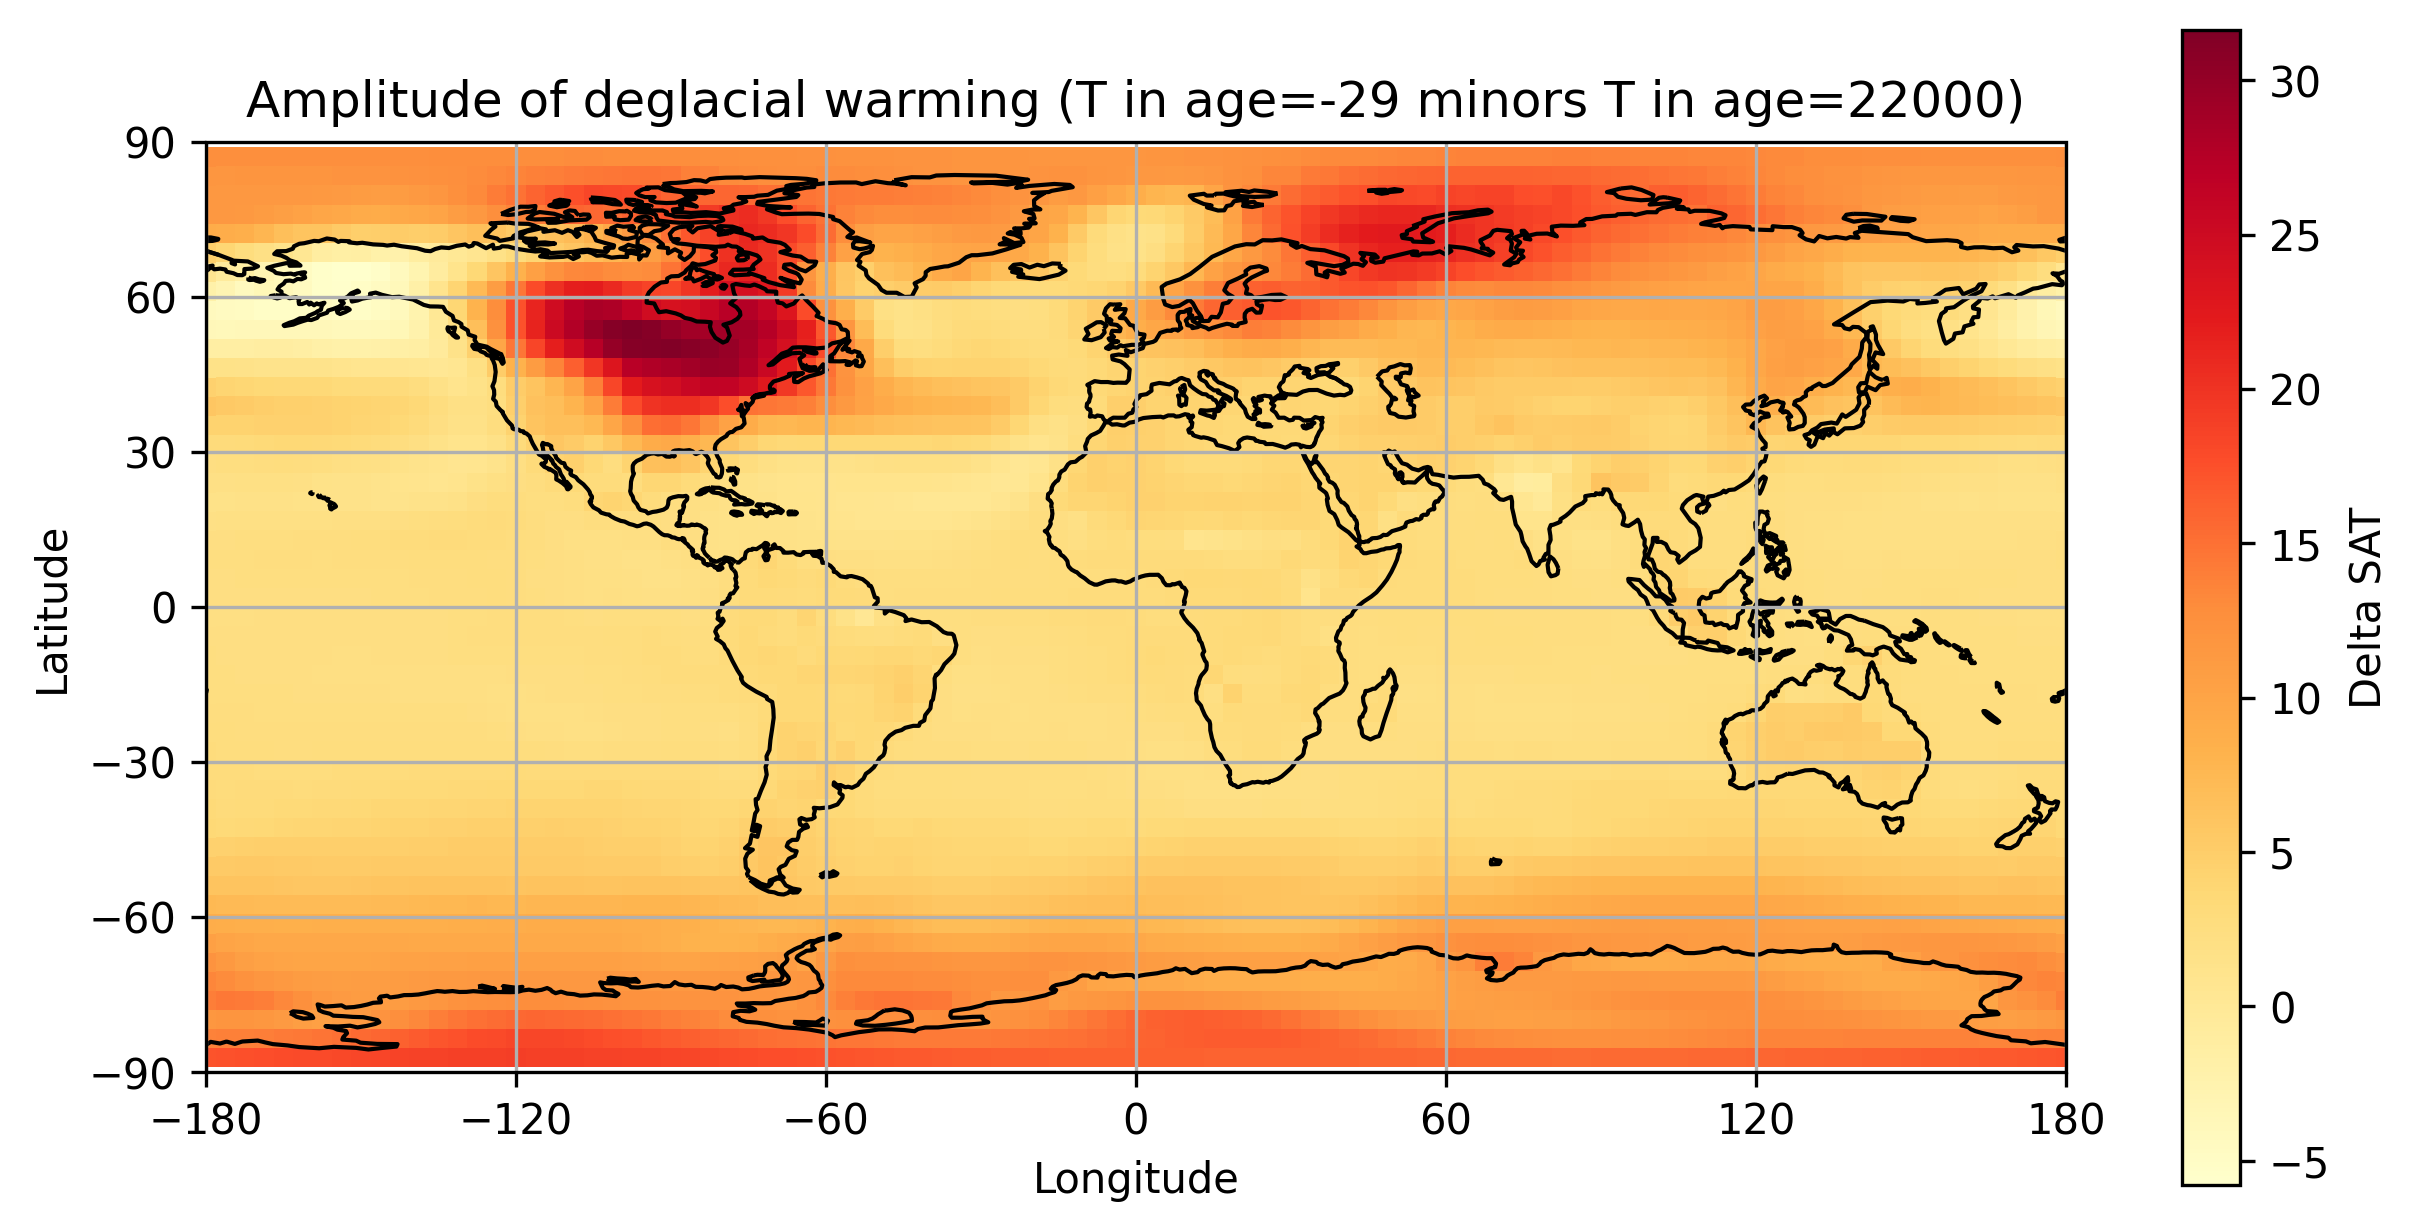

In [3]:
plot_sat(ds)

# Randomly sample 64 time series and plot them

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

def random_64(ds, variable='sat',num_samples=64):
    # Select random samples from the lat and lon dimensions
    lat_samples = np.random.randint(0, ds.dims['lat'], size=num_samples)
    lon_samples = np.random.randint(0, ds.dims['lon'], size=num_samples)

    # Extract the age and sat values for the selected samples
    age_vals = ds.age.values
    sat_vals = ds[variable].values[:, lat_samples, lon_samples]

    ncol = 8
    nrow = int(np.ceil(num_samples / ncol))
    fig,axs=plt.subplots(nrow,ncol,figsize=(20,20),dpi=300)
    for i in range(num_samples):
        ax=axs[int(i/ncol),i%ncol]
        ax.plot(age_vals, sat_vals[:, i])
        # invert the x-axis
        ax.invert_xaxis()
        # ax.plot(ds.age_transition.values[lat_samples[i], lon_samples[i]], ds.sat_transition.values[lat_samples[i], lon_samples[i]], 'ro')
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xlabel('Age')
        ax.set_ylabel('SAT')
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

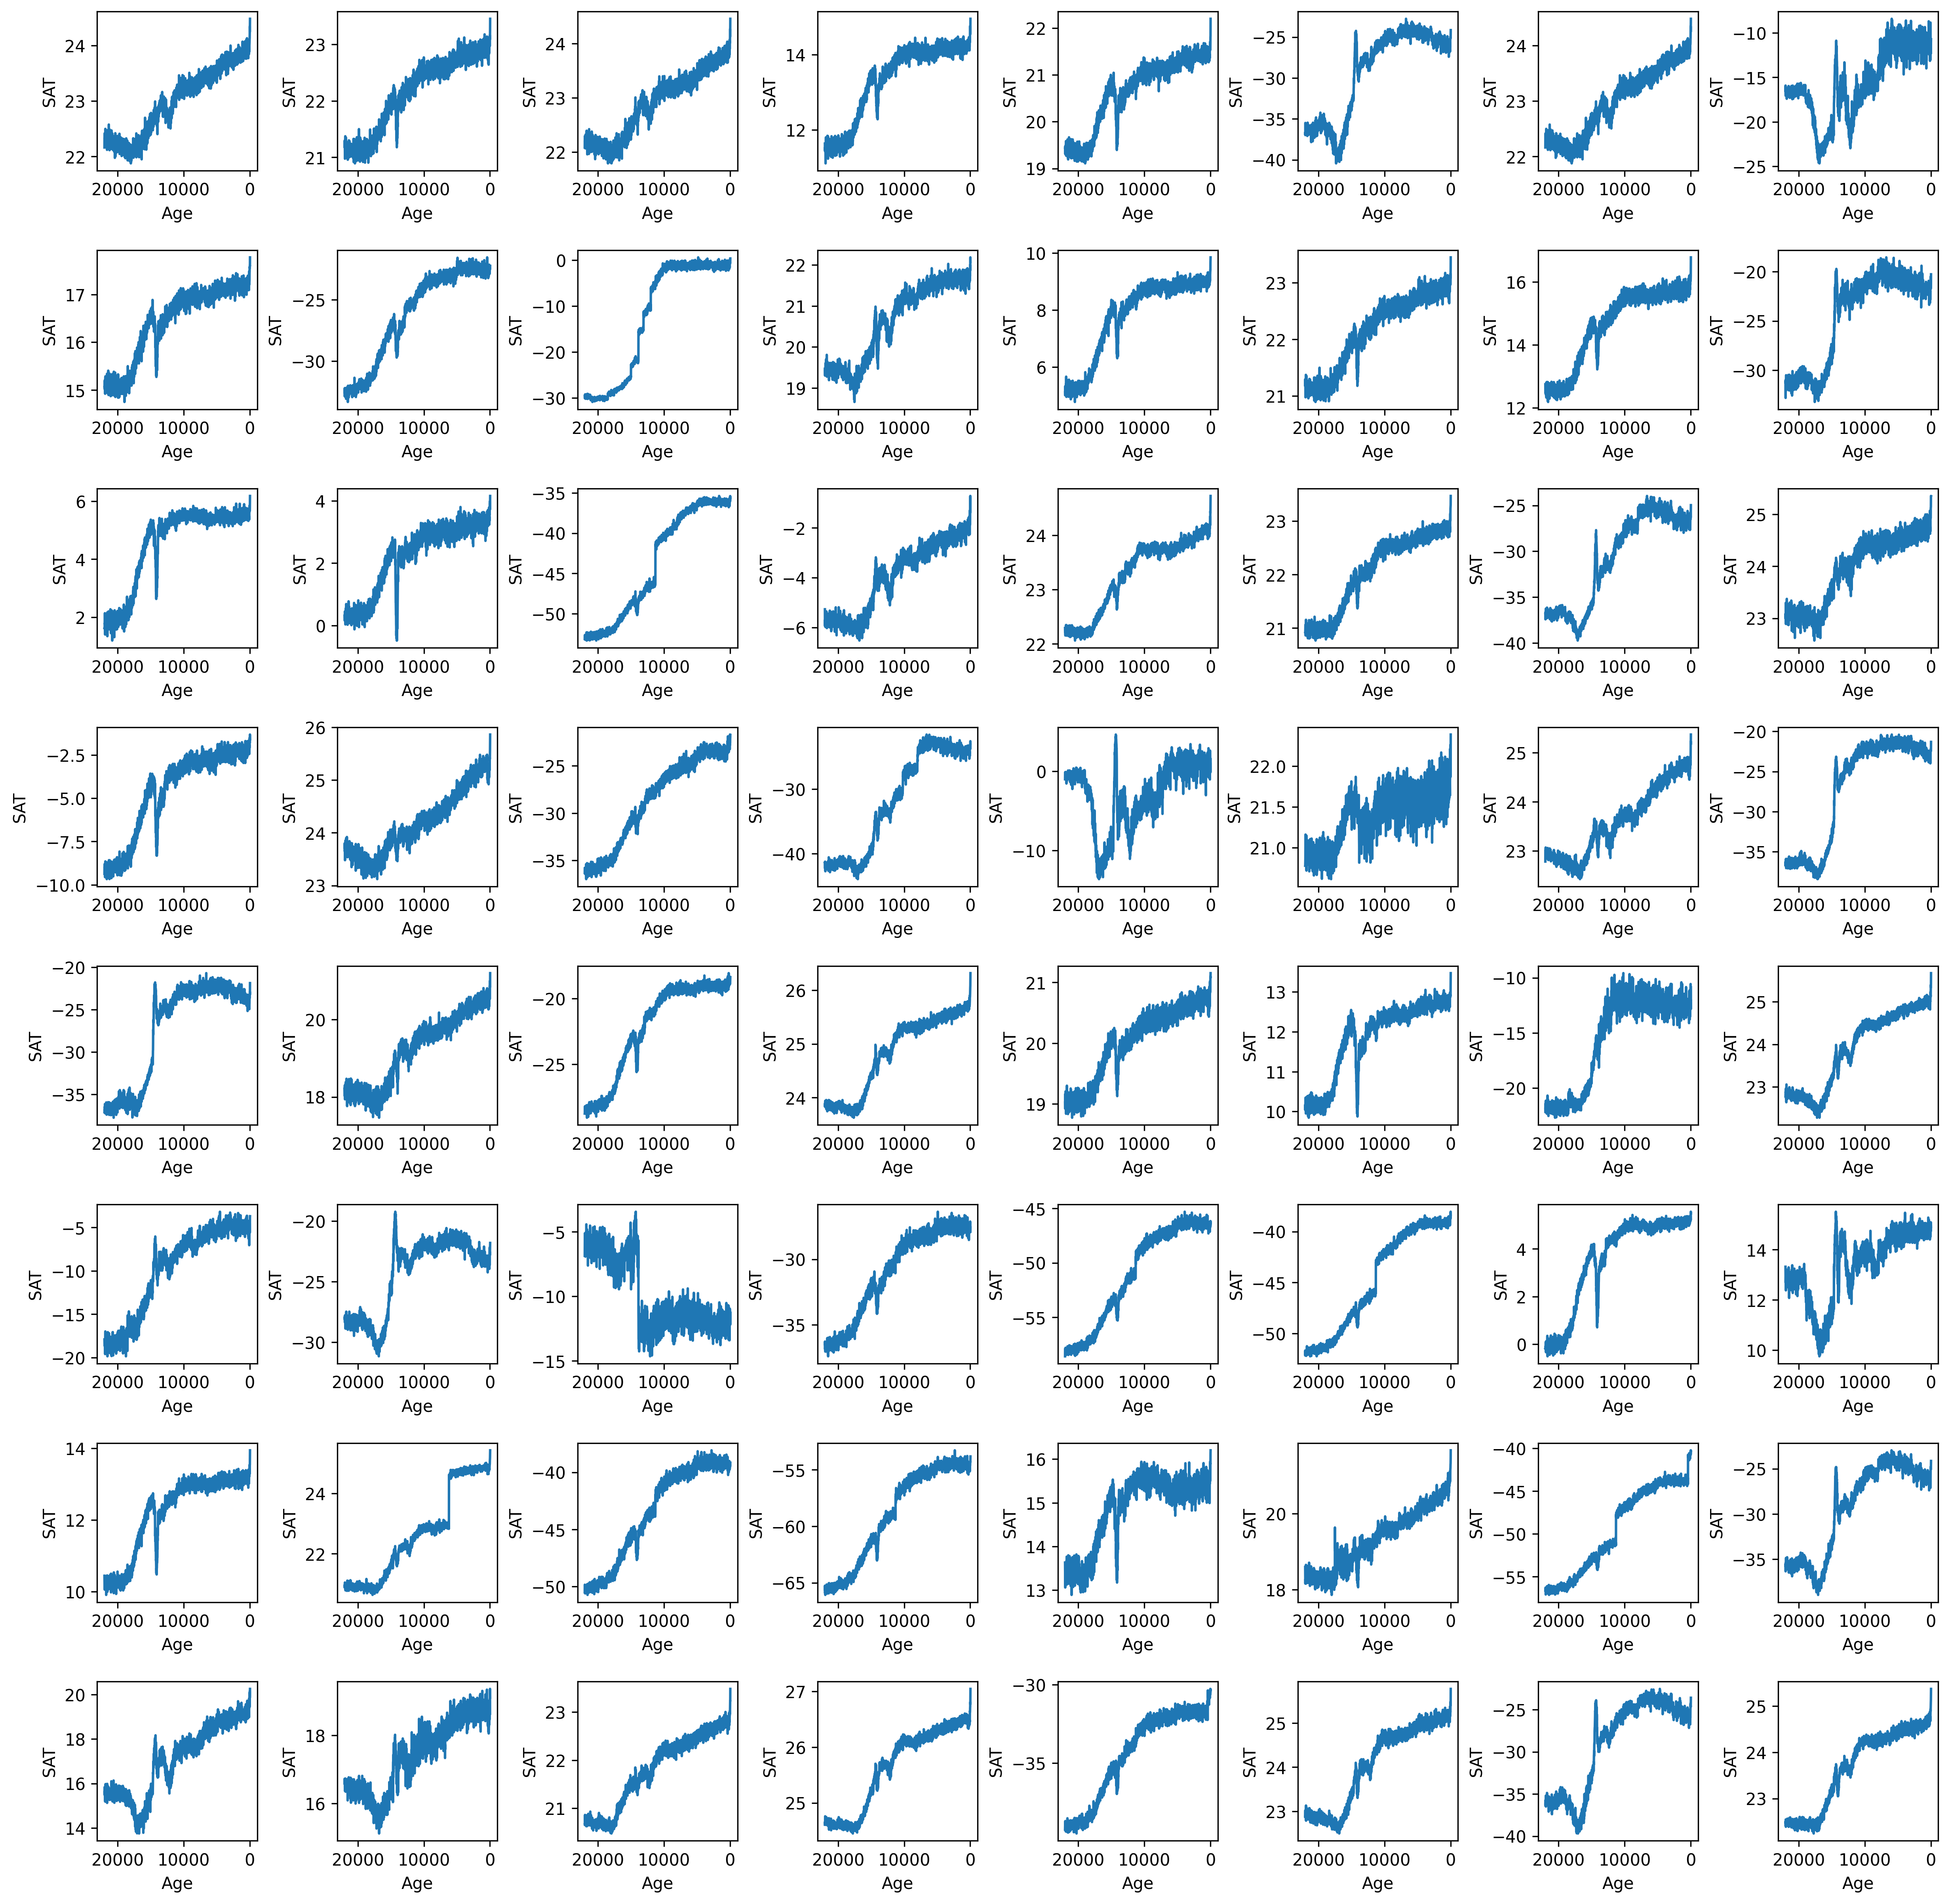

In [5]:
random_64(ds)

# The age of LGMR data starts from 100 and ends at 23900 with step of 200 yr. The age of TraCE starts from -29 and ends at 22000, so we resample the TraCE data to match the resolution of LGMR

In [6]:
# import numpy as np
# import xarray as xr


# # Create a new 'age' coordinate with the desired values
# new_age = np.arange(100, 22001, 200)

# # Interpolate the 'sat' data variable to the new 'age' coordinate
# resampled_sat = ds['sat'].interp(age=new_age)

# # Create a new xarray Dataset with the resampled 'sat' data variable
# ds_sat = resampled_sat.to_dataset(name='sat')

# ds_sat

<xarray.Dataset>
Dimensions:  (lat: 48, lon: 96, age: 110)
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * age      (age) int32 100 300 500 700 900 ... 21100 21300 21500 21700 21900
Data variables:
    sat      (age, lat, lon) float64 -41.41 -41.8 -42.21 ... -36.63 -36.52

# Alternative: don't resample the data

In [34]:
ds_sat=ds

# Crop the data for age>11

In [21]:

# ds_sat = ds_sat.where(ds_sat.age>=11000, drop=True)

# PCA

shape of the weight: (48,)
shape of the reshaped sat_centered_weighted: (2204, 4608)


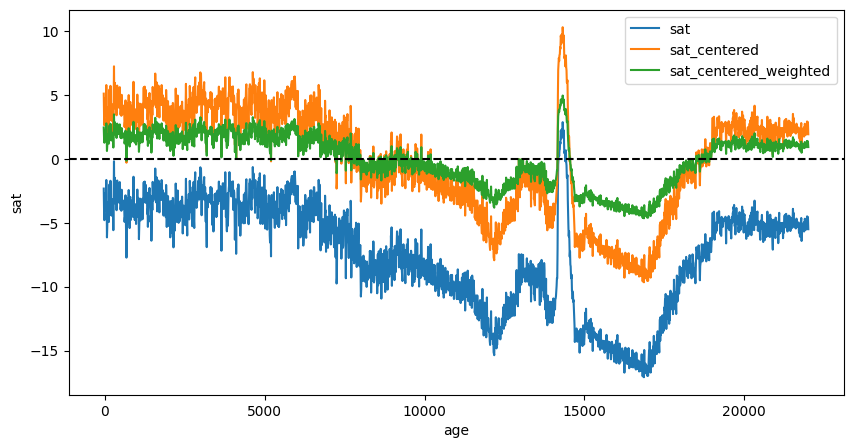

In [35]:
from toolbox import PCA_functions as pf
# 1. Center the Data
ds_sat = pf.center_data(ds_sat)

# 2. Weight the Data
ds_sat = pf.apply_weighting(ds_sat)

# 3. Plot the Centered and Weighted Data
# Assuming you want to plot data for lat=0 and lon=0
lat_index = 40
lon_index = 90
pf.plot_sat_variables(ds_sat, lat_index, lon_index)


In [36]:
from toolbox import PCA_functions as pf
# 4. Perform PCA
exp_variance, eofs, pcs = pf.sat_PCA(ds_sat)
print('Explained variance:', exp_variance)


shape of the reshaped sat_centered_weighted: (4608, 2204)
shape of u, s, vh: (4608, 4608) (2204,) (2204, 2204)
shape of EOFs: (4608, 2)
shape of PCs: (2204, 2)
Explained variance: [9.05370503e-01 5.56376438e-02 1.35933226e-02 ... 1.74683888e-10
 1.70352439e-10 1.65461020e-11]


In [ ]:
# 5. Plot PCs
pf.plot_pcs(ds_sat['age'].values, pcs, exp_variance)

# 6. Plot EOF Scatter
pf.plot_eof_scatter(eofs)

# 7. Plot the EOF Map
pf.plot_eof_map(eofs, ds_sat['lat'].values, ds_sat['lon'].values)

# GMM

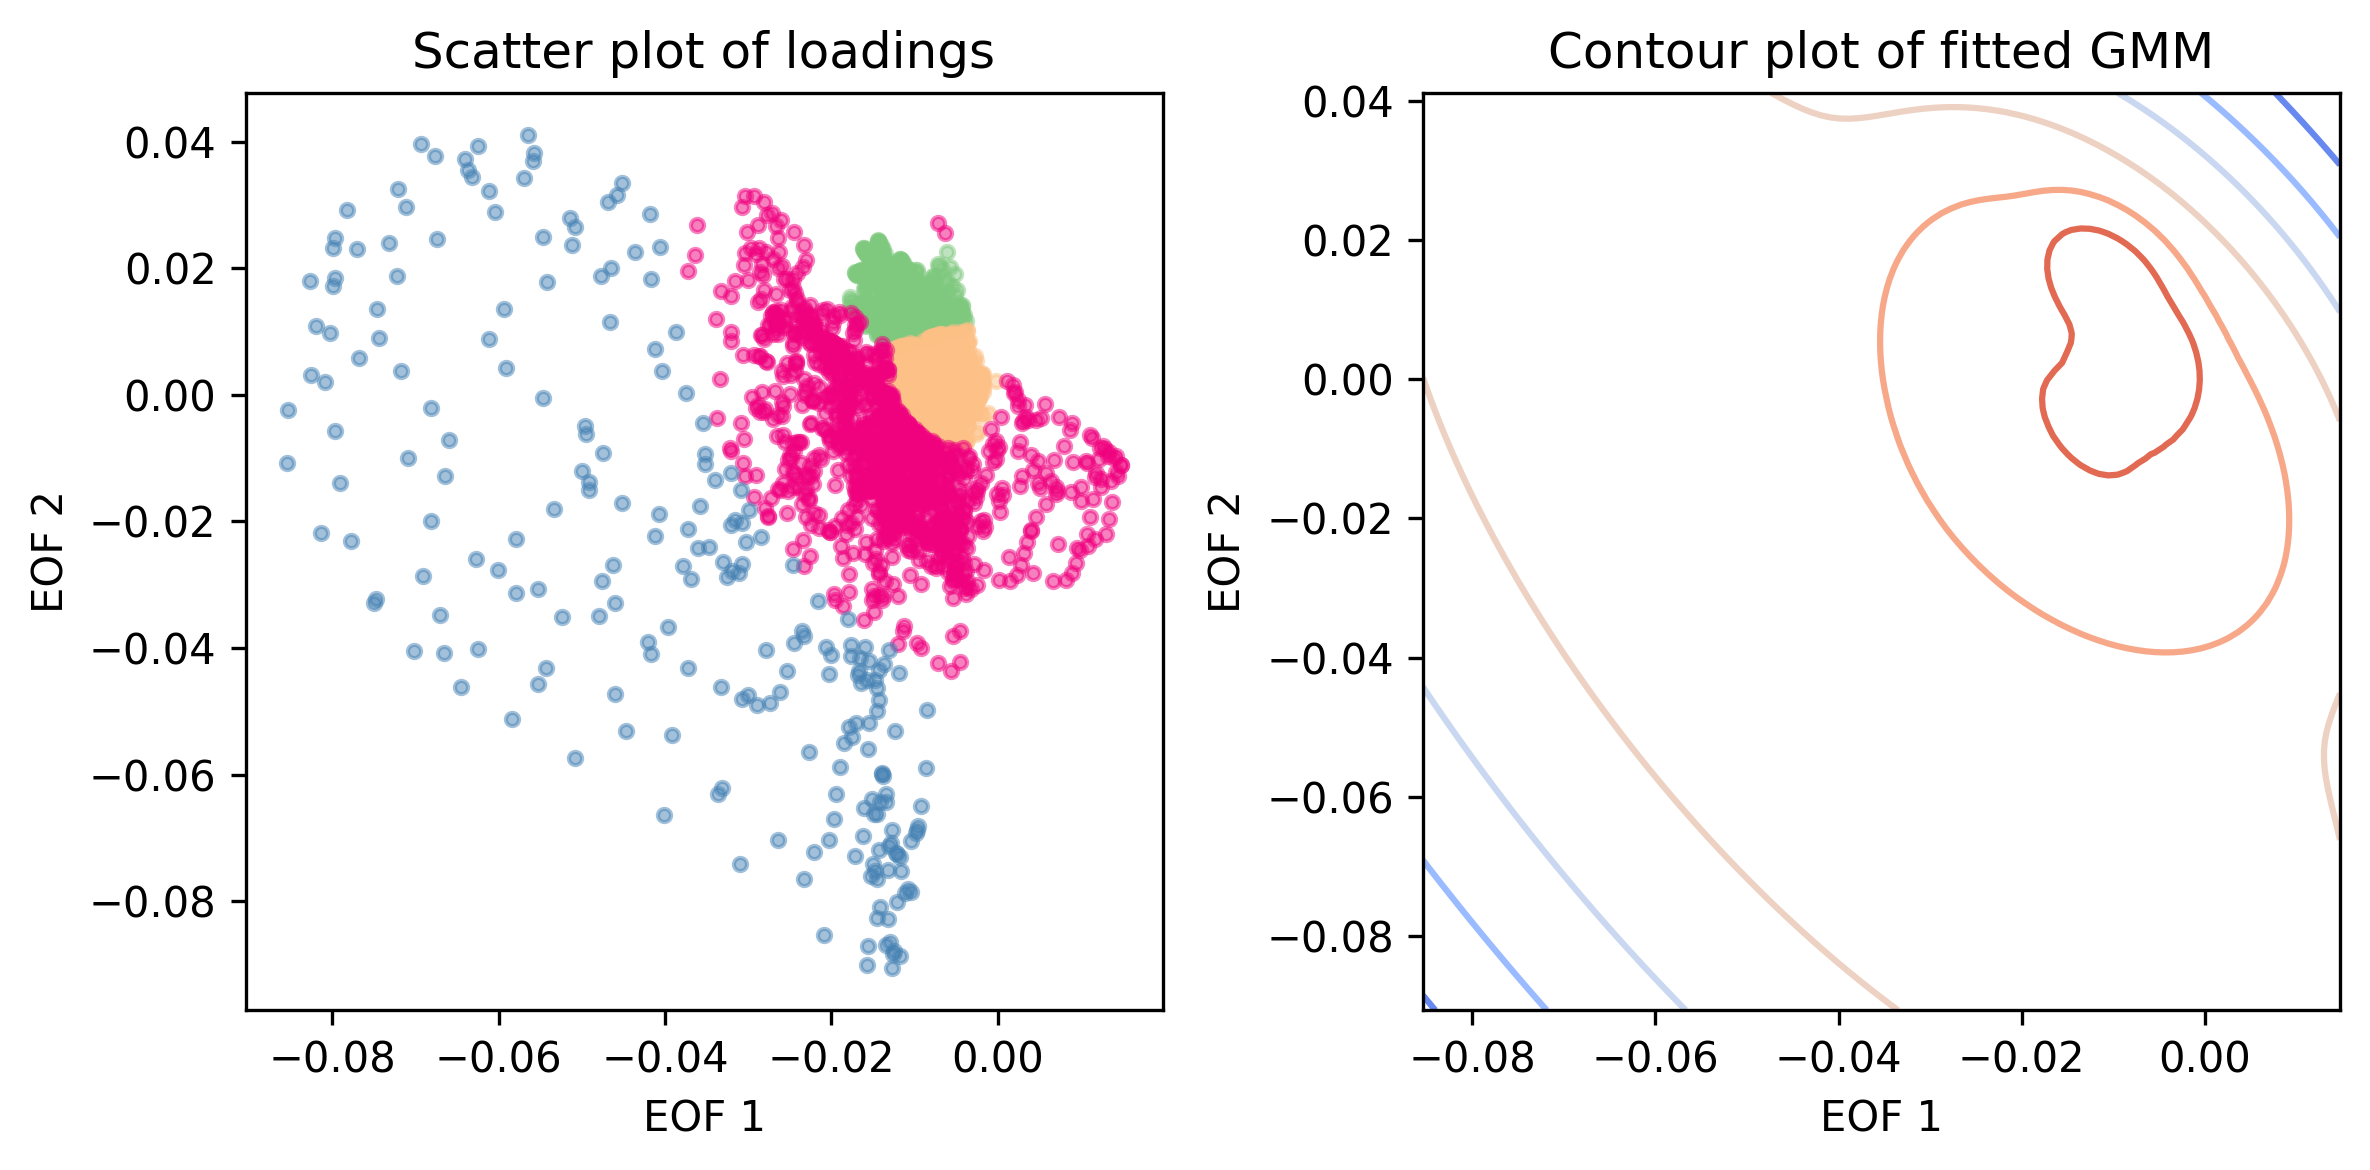

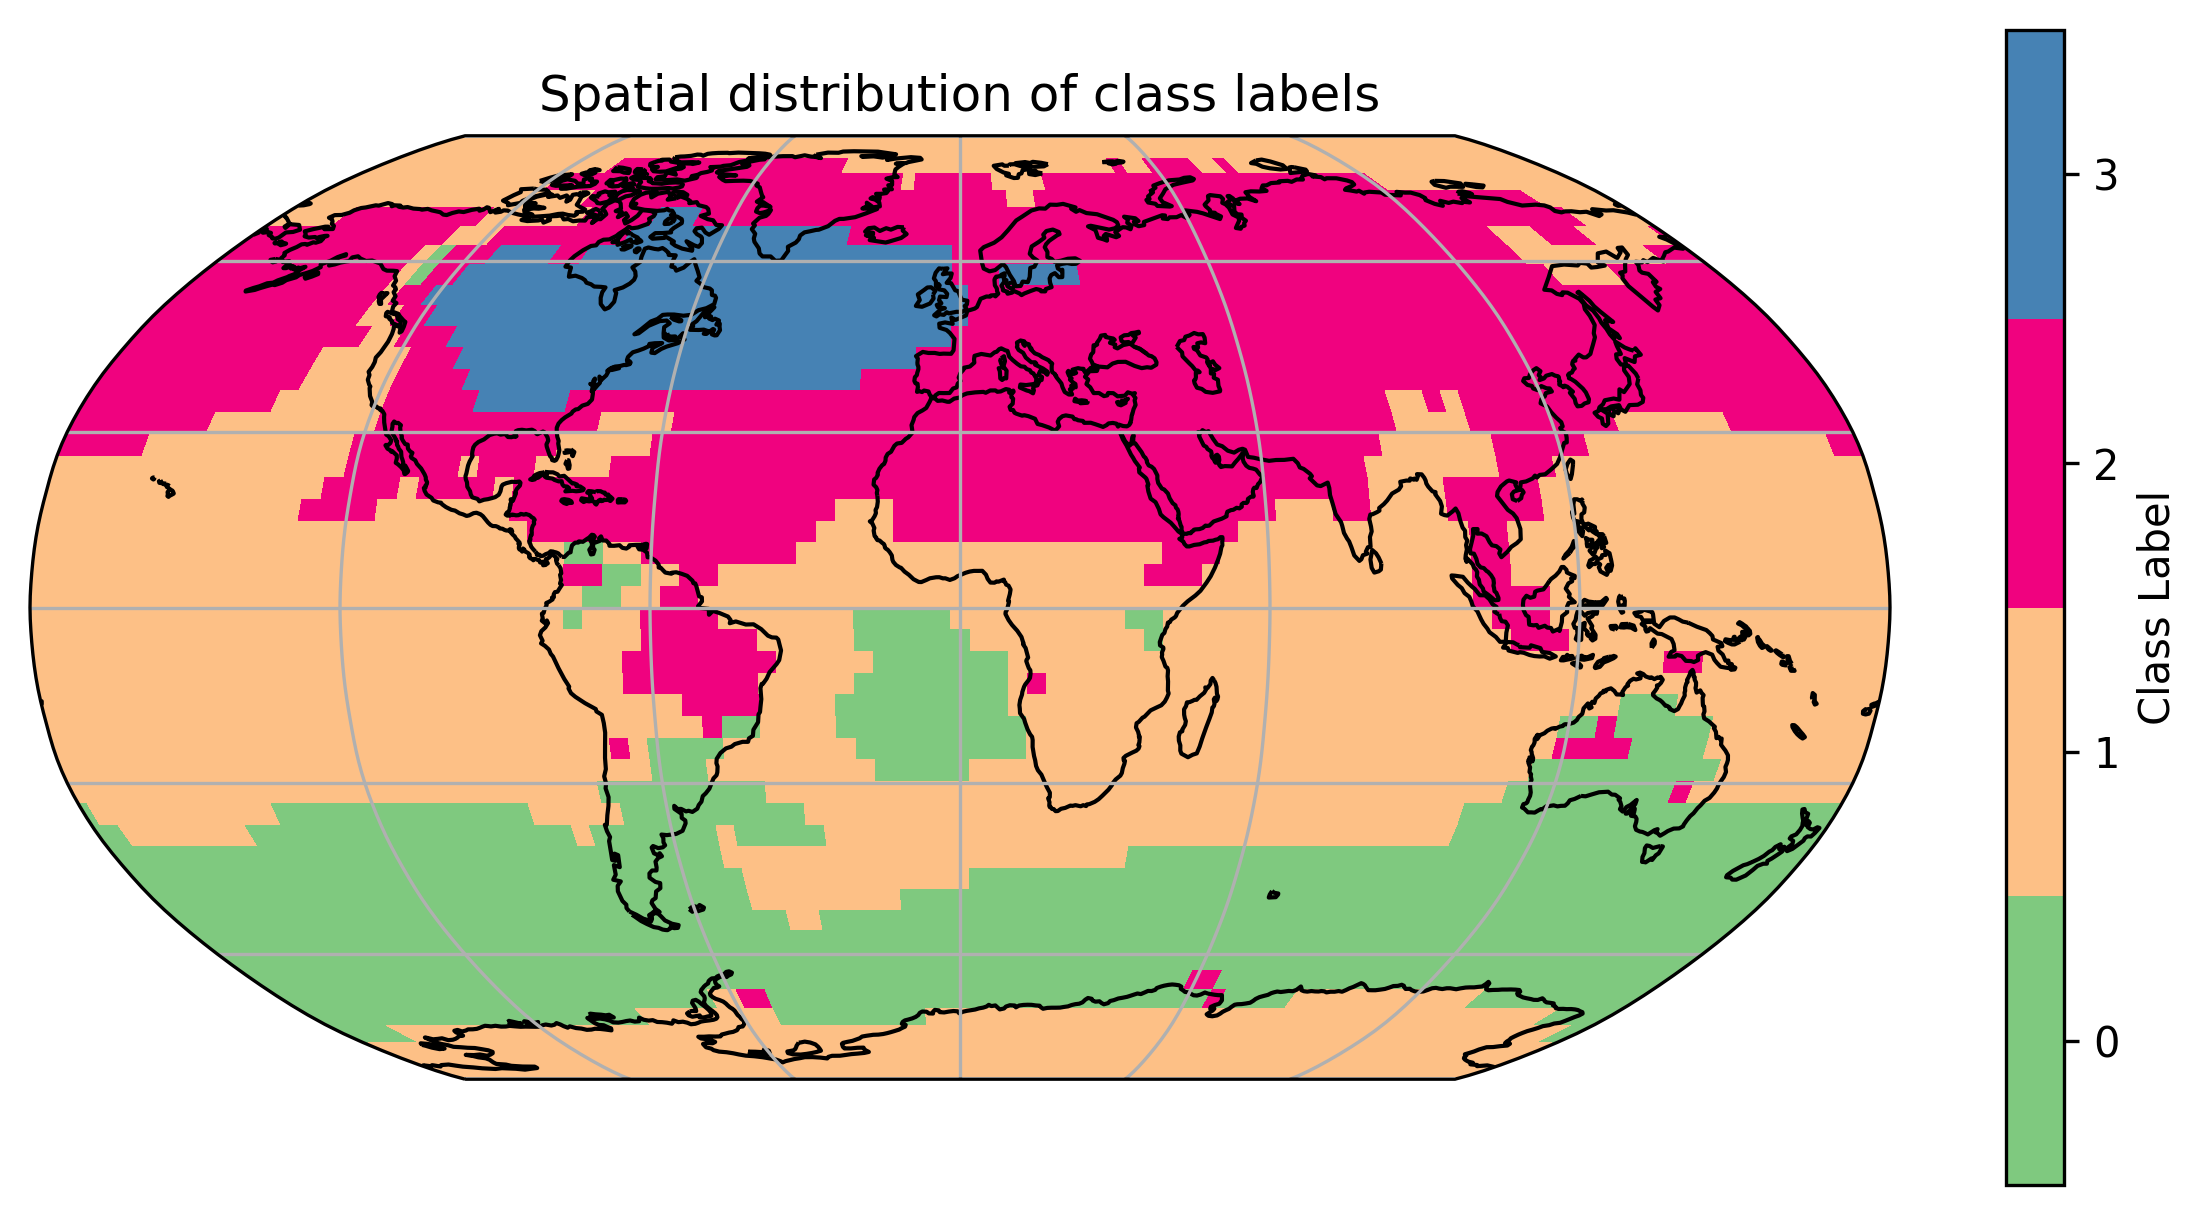

In [38]:
from toolbox import GMM_functions as gf
ds_EOFs_GMM=gf.GMM4EOFS(eofs, ds_sat,n_components=4)
gf.plot_labels(ds_EOFs_GMM)

In [47]:
from toolbox import GMM_functions as gf
import importlib
importlib.reload(gf)

uncor_weighted_avg=gf.plot_weighted_average_curve(ds_EOFs_GMM.copy(), dpi=900)